# Style Transfer

<img src="https://i0.wp.com/chelseatroy.com/wp-content/uploads/2018/12/neural_style_transfer.png?resize=768%2C311&ssl=1">

La idea de este trabajo final es reproducir el siguiente paper:

https://arxiv.org/pdf/1508.06576.pdf

El objetivo es transferir el estilo de una imagen dada a otra imagen distinta. 

Como hemos visto en clase, las primeras capas de una red convolucional se activan ante la presencia de ciertos patrones vinculados a detalles muy pequeños.

A medida que avanzamos en las distintas capas de una red neuronal convolucional, los filtros se van activando a medida que detectan patrones de formas cada vez mas complejos.

Lo que propone este paper es asignarle a la activación de las primeras capas de una red neuronal convolucional (por ejemplo VGG19) la definición del estilo y a la activación de las últimas capas de la red neuronal convolucional, la definición del contenido.

La idea de este paper es, a partir de dos imágenes (una que aporte el estilo y otra que aporte el contenido) analizar cómo es la activación de las primeras capas para la imagen que aporta el estilo y cómo es la activación de las últimas capas de la red convolucional para la imagen que aporta el contenido. A partir de esto se intentará sintetizar una imagen que active los filtros de las primeras capas que se activaron con la imagen que aporta el estilo y los filtros de las últimas capas que se activaron con la imagen que aporta el contenido.

A este procedimiento se lo denomina neural style transfer.

# En este trabajo se deberá leer el paper mencionado y en base a ello, entender la implementación que se muestra a continuación y contestar preguntas sobre la misma.

# Una metodología posible es hacer una lectura rápida del paper (aunque esto signifique no entender algunos detalles del mismo) y luego ir analizando el código y respondiendo las preguntas. A medida que se planteen las preguntas, volviendo a leer secciones específicas del paper terminará de entender los detalles que pudieran haber quedado pendientes.

Lo primero que haremos es cargar dos imágenes, una que aporte el estilo y otra que aporte el contenido. A tal fin utilizaremos imágenes disponibles en la web.

In [1]:
# # Imagen para estilo
# !wget https://upload.wikimedia.org/wikipedia/commons/5/52/La_noche_estrellada1.jpg

# # Imagen para contenido
# !wget https://upload.wikimedia.org/wikipedia/commons/thumb/f/f4/Neckarfront_T%C3%BCbingen_Mai_2017.jpg/775px-Neckarfront_T%C3%BCbingen_Mai_2017.jpg

# # # Creamos el directorio para los archivos de salida
# # !mkdir content/output

In [2]:
from keras.preprocessing.image import load_img, save_img, img_to_array
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
import time
import argparse

from keras.applications import vgg19
from keras import backend as K
from pathlib import Path
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [3]:
# Definimos las imagenes que vamos a utilizar, y el directorio de salida

base_image_path = Path("inputs/775px-Neckarfront_TÃ¼bingen_Mai_2017.jpg")
style_reference_image_path = Path("inputs/La_noche_estrellada1.jpg")
result_prefix = Path("outputs")
iterations = 100

# 1) En base a lo visto en el paper ¿Qué significan los parámetros definidos en la siguiente celda?

Respuesta:
* **total_variation_weight**: Factor de suavizamiento de la loss.
* **style_weight**: Representa el factor Beta mencionado en el paper, es decir, la ponderación que se le brinda a la representación del estilo, la apariencia.
* **content_weight**: Representa el peso que se le otorga en el modelo al contenido de la fotografía bajo analisis. Es el factor alfa nombrado en el artículo.

In [4]:
total_variation_weight = 0.1
style_weight = 10
content_weight = 1

In [5]:
# Definimos el tamaño de las imágenes a utilizar
width, height = load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

# 2) Explicar qué hace la siguiente celda. En especial las últimas dos líneas de la función antes del return. ¿Por qué?

Ayuda: https://keras.io/applications/

In [6]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols)) #
    img = img_to_array(img) 
    img = np.expand_dims(img, axis=0) 
    img = vgg19.preprocess_input(img)
    return img

Respuesta:

* **load_img()**: Esta función nos permite cargar una imagen, guardada en la ruta especificada, como un objeto de imagen PIL. En especial, en este ejemplo se utiliza uno de los argumentos adicionales que tiene la misma, como lo es el 'target_size', el cual permite cambiar el tamaño original de la imagen por otro deseado. 
* **img_to_array()**: Convierte la imagen cargada en formato PIL en un NumPy array para facilitar el empleo de modelos de deep learning. El objeto, entonces, pasa a tener tamaño (img_nrows, img_ncols,3), donde el último elemento (3) representa los canales de la imagen.
* **expand_dims()**: Esta función se utiliza para expandir la dimensión de la  matriz generada en el paso previo. En particular, inserta un nuevo elemento que representará la cantidad de imágenes a procesar.
* **vgg19.preprocess_input**: Preprocesa la matriz que codifica la imagen, con el fin de adecuarla al formato que requiere el modelo. Más específicamente, convierte la imagen de RGB a BGR, luego le resta la media de los canales de color del conjunto de datos ImageNet sin escalar. Esto se debe a que el modelo que está utilizando se ha entrenado en un conjunto de datos diferente.

**A continuación corro paso a paso los componentes de la función con la imagen base, con el objeto de demostrar la explicación desarrollada:**

In [7]:
#load_img(): carga la imagen y le cambia el tamaño a (img_nrows, img_ncols)
img = load_img(base_image_path, target_size=(img_nrows, img_ncols)) 
print('Tipo de objeto :'+str(type(img)))
print('Tamaño :'+str(img.size))

Tipo de objeto :<class 'PIL.Image.Image'>
Tamaño :(517, 400)


In [8]:
#img_to_array(): convierte la imagen a un numpy array y le agrega los canales
img = img_to_array(img)
print('Tipo de objeto :'+str(type(img)))
print('Tamaño :'+str(img.shape))

Tipo de objeto :<class 'numpy.ndarray'>
Tamaño :(400, 517, 3)


In [9]:
#expand_dims(): agrega el número de imagenes:
img = np.expand_dims(img, axis=0)
print('Tipo de objeto :'+str(type(img)))
print('Tamaño :'+str(img.shape))
img

Tipo de objeto :<class 'numpy.ndarray'>
Tamaño :(1, 400, 517, 3)


array([[[[196., 202., 202.],
         [201., 205., 206.],
         [204., 208., 209.],
         ...,
         [121., 128., 138.],
         [120., 127., 137.],
         [119., 126., 136.]],

        [[189., 194., 197.],
         [192., 197., 200.],
         [196., 200., 203.],
         ...,
         [118., 125., 135.],
         [117., 124., 134.],
         [115., 122., 132.]],

        [[189., 194., 197.],
         [192., 197., 200.],
         [194., 199., 202.],
         ...,
         [118., 125., 135.],
         [117., 124., 134.],
         [116., 123., 133.]],

        ...,

        [[130., 152., 129.],
         [  0.,  14.,   0.],
         [ 15.,  26.,   9.],
         ...,
         [ 65.,  67.,   4.],
         [ 62.,  64.,   1.],
         [ 72.,  74.,  11.]],

        [[  0.,  13.,   2.],
         [  0.,   5.,   0.],
         [  4.,  11.,   3.],
         ...,
         [ 62.,  67.,   3.],
         [ 61.,  66.,   2.],
         [ 70.,  72.,   9.]],

        [[ 64.,  74.,  76.],
       

In [10]:
#vgg19.preprocess_input(): re-escala el array de modo tal de convertir el input en un formato adecuado para el modelo en cuestión
img = vgg19.preprocess_input(img)
print('Tipo de objeto :'+str(type(img)))
print('Tamaño :'+str(img.shape))
img

Tipo de objeto :<class 'numpy.ndarray'>
Tamaño :(1, 400, 517, 3)


array([[[[  98.061    ,   85.221    ,   72.32     ],
         [ 102.061    ,   88.221    ,   77.32     ],
         [ 105.061    ,   91.221    ,   80.32     ],
         ...,
         [  34.060997 ,   11.221001 ,   -2.6800003],
         [  33.060997 ,   10.221001 ,   -3.6800003],
         [  32.060997 ,    9.221001 ,   -4.6800003]],

        [[  93.061    ,   77.221    ,   65.32     ],
         [  96.061    ,   80.221    ,   68.32     ],
         [  99.061    ,   83.221    ,   72.32     ],
         ...,
         [  31.060997 ,    8.221001 ,   -5.6800003],
         [  30.060997 ,    7.2210007,   -6.6800003],
         [  28.060997 ,    5.2210007,   -8.68     ]],

        [[  93.061    ,   77.221    ,   65.32     ],
         [  96.061    ,   80.221    ,   68.32     ],
         [  98.061    ,   82.221    ,   70.32     ],
         ...,
         [  31.060997 ,    8.221001 ,   -5.6800003],
         [  30.060997 ,    7.2210007,   -6.6800003],
         [  29.060997 ,    6.2210007,   -7.6800003]],

# 3) Habiendo comprendido lo que hace la celda anterior, explique de manera muy concisa qué hace la siguiente celda. ¿Qué relación tiene con la celda anterior?

In [11]:
def deprocess_image(x):
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

Respuesta:

Esta función restaura los valores de píxeles en la imagen de salida a sus valores originales antes de la estandarización. Esto es, permite recuperar las características perdidas de la imagen al preprocesar de la manera en que lo requiere la VGG19 de Keras. 
Esto implica la eliminación del re-shape hecho. Es decir, elimina la dimensión correspondiente al batch, remueve el centrado en cero (103.939, 116.779 y 123.68 son las medias de los canales del Imagen Net que fueron restadas en el preprocesamiento, por eso es que se adicionan aca) y, finalmente, convierte la imagen de BGR a RGB.

In [12]:
# get tensor representations of our images
# K.variable convierte un numpy array en un tensor, para 
base_image = K.variable(preprocess_image(base_image_path))
style_reference_image = K.variable(preprocess_image(style_reference_image_path))

In [13]:
combination_image = K.placeholder((1, img_nrows, img_ncols, 3))

Aclaración:

La siguiente celda sirve para procesar las tres imagenes (contenido, estilo y salida) en un solo batch.

In [14]:
# combine the 3 images into a single Keras tensor
input_tensor = K.concatenate([base_image,
                              style_reference_image,
                              combination_image], axis=0)

In [15]:
# build the VGG19 network with our 3 images as input
# the model will be loaded with pre-trained ImageNet weights
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet', include_top=False)
print('Model loaded.')

# get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

Model loaded.


# 4) En la siguientes celdas:

- ¿Qué es la matriz de Gram?¿Para qué se usa?
- ¿Por qué se permutan las dimensiones de x?

In [16]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

Respuesta:

La matriz de Gram es la multiplicación de una matriz con su transpuesta. En la función permutamos las dimensiones de x con el fin de obtener las dimensiones correctas para aplicar luego el producto entre las matrices. 

Al utilizar esta herramienta, en vez de tomar la imagen directamente, podemos profundizar en las relaciones espaciales a través de la imagen y no solo mirar los valores de los píxeles.

En este caso de análisis en particular, la matriz de Gram la usamos únicamente para la imagen de estilo y no para la de contenido. Esto se debe a que en la imagen de contenido, lo que buscamos es que se conserven las características espaciales exactas de la imagen. Es decir, si usamos una casa como imagen de contenido, queremos que la estructura de la casa sea visible en la imagen generada. Por el contrario, en el caso del estilo, no nos interesan en sí las características espaciales de la imagen, sino que lo que buscamos es que se conserve el estilo general. Por lo tanto, al usar esta matriz, perdemos las características espaciales exactas pero ganamos en tanto estilo.

# 5) Losses:

Explicar qué mide cada una de las losses en las siguientes tres celdas.

In [17]:
def style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return K.sum(K.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

In [18]:
def content_loss(base, combination):
    return K.sum(K.square(combination - base))


In [19]:
def total_variation_loss(x):
    assert K.ndim(x) == 4
    a = K.square(
        x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
    b = K.square(
        x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

Respuesta:

* **style_loss:** esta función permite medir la diferencia de estilo entre la imagen sintetizada y la imagen de estilo, en otras palabras, el objetivo de la misma es el de mantener el estilo de la imagen de referencia en la imagen generada. Se basa en la matriz de Gram, dado que como se explicó anteriormente, permite capturar el estilo.

* **content_loss:** mide la diferencia en las características del contenido entre la imagen sintetizada y la imagen de contenido. Esta función está diseñada para mantener el 'contentido' de la imagen base en la imagen generada, es decir, mantener una buena representación de la imagen base.

* **total_variation_loss:** A veces, la imagen aprendida tiene mucho ruido de alta frecuencia, es decir, tiene píxeles particularmente brillantes u oscuros. Un método común de reducción de ruido es la eliminación de ruido de variación total, que es justamente lo que se busca hacer en esta tercer función de perdida. Esto es, está diseñada para mantener la coherencia de la imagen generada.

In [20]:
# Armamos la loss total
loss = K.variable(0.0)
layer_features = outputs_dict['block5_conv2']
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss = loss + content_weight * content_loss(base_image_features,
                                            combination_features)

feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']
for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :] 
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss = loss + (style_weight / len(feature_layers)) * sl
loss = loss + total_variation_weight * total_variation_loss(combination_image)

In [21]:
grads = K.gradients(loss, combination_image)

outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)

f_outputs = K.function([combination_image], outputs)

# 6) Explique el propósito de las siguientes tres celdas. ¿Qué hace la función fmin_l_bfgs_b? ¿En qué se diferencia con la implementación del paper? ¿Se puede utilizar alguna alternativa?

Respuesta:

Las tres celdas siguientes iteran n veces el proceso de optimización para lograr generar imágenes que se acerquen cada vez más al resultado deseado. 

La función fmin_l_bfgs_b minimiza una función "evaluator.loss" empleando el algoritmo L-BFGS-B (algoritmo de optimización que aproxima el algoritmo de Broyden-Fletcher-Goldfarb-Shanno empleando una cantidad limitada de memoria). Se diferencia de la implementación del paper en tanto en este último se empleó descenso de gradiente. 

Como alternativa se podría utilizar, por ejemplo, Adam, RMSProp o descenso del gradiente como se realiza en el paper.

In [22]:
def eval_loss_and_grads(x):
    x = x.reshape((1, img_nrows, img_ncols, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

# this Evaluator class makes it possible
# to compute loss and gradients in one pass
# while retrieving them via two separate functions,
# "loss" and "grads". This is done because scipy.optimize
# requires separate functions for loss and gradients,
# but computing them separately would be inefficient.

Devuelve la loss y el gradiente, f_outputs recibe una imagen y devuelve la loss y el gradiente

In [23]:
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

# 7) Ejecute la siguiente celda y observe las imágenes de salida en cada iteración.

In [24]:
# evaluator = Evaluator()

# # run scipy-based optimization (L-BFGS) over the pixels of the generated image
# # so as to minimize the neural style loss
# x = preprocess_image(base_image_path)

# for i in range(iterations):
#     print('Start of iteration', i)
#     start_time = time.time()
#     x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
#                                      fprime=evaluator.grads, maxfun=20)
#     print('Current loss value:', min_val)
#     # save current generated image
#     img = deprocess_image(x.copy())
#     fname = result_prefix / ('output_at_iteration_%d.png' % i)
#     save_img(fname, img)
#     end_time = time.time()
#     print('Image saved as', fname)
#     print('Iteration %d completed in %ds' % (i, end_time - start_time))

Resultado


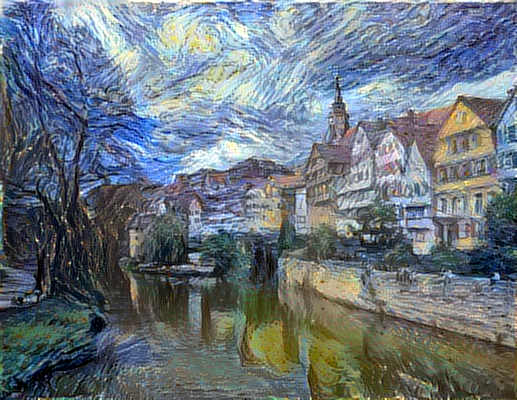

In [25]:
print('Resultado')
load_img('outputs/output_at_iteration_99_orig.png', target_size=(img_nrows, img_ncols)) 

# 8) Generar imágenes para distintas combinaciones de pesos de las losses. Explicar las diferencias. (Adjuntar las imágenes generadas como archivos separados.)

Respuesta:


**Caso I**

En este experimento solo se modificó el párametro relacionado al contenido:
* total_variation_weight = 0.1
* style_weight = 10
* content_weight = 200

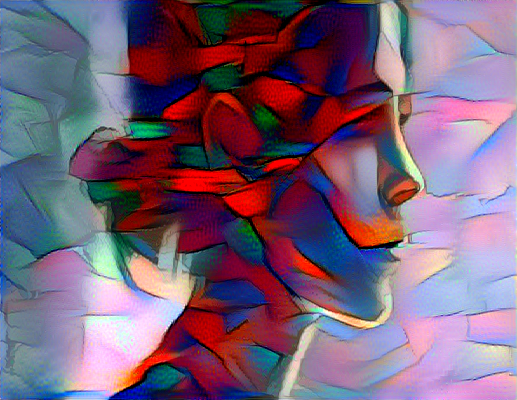

In [26]:
load_img('outputs/output_at_iteration_99_I.png', target_size=(img_nrows, img_ncols)) 

Tal como se supuso, se puede apreciar en este resultado, una mayor claridad las características iniciales del contenido la imagen base.

**Caso II**

En este ejemplo, se le otorgó mayor preponderancia al estilo:
* total_variation_weight = 0.1
* style_weight = 200
* content_weight = 1

In [27]:
load_img('outputs/output_at_iteration_99_II.png', target_size=(img_nrows, img_ncols)) 

FileNotFoundError: [Errno 2] No such file or directory: 'outputs/output_at_iteration_99_II.png'

Se aprecia claramente respecto del ejemplo anterior, que aquí se le dio mayor peso relativo al estilo, dado que ya los razgos iniciales de la imagen base pierden nitidez y gana relevancia el estilo aplicado.

**Caso III**

Se varió únicamente el factor relacionado al suavizamiento de la loss:
* total_variation_weight = 0.9
* style_weight = 10
* content_weight = 1

In [ ]:
load_img('outputs/output_at_iteration_99_III.png', target_size=(img_nrows, img_ncols)) 


# 9) Cambiar las imágenes de contenido y estilo por unas elegidas por usted. Adjuntar el resultado.

Respuesta:

* **Ejemplo I:**

In [ ]:
print('Imagen base:')
load_img('inputs/I_image_conten.jpg', target_size=(img_nrows, img_ncols))

In [ ]:
print('Imagen de estilo:')
load_img('inputs/I_image_style.jpg', target_size=(img_nrows, img_ncols))

In [ ]:
print('Resultado:')
load_img('outputs/output_at_iteration_99_I.png', target_size=(img_nrows, img_ncols))

* **Ejemplo II:**

In [ ]:
print('Imagen base:')
load_img('inputs/II_image_conten.jpg', target_size=(img_nrows, img_ncols))

In [ ]:
print('Imagen de estilo:')
load_img('inputs/II_image_style.jpg', target_size=(img_nrows, img_ncols))

In [ ]:
# print('Resultado:')
# load_img('outputs/output_at_iteration_99_II.png', target_size=(img_nrows, img_ncols))

* **Ejemplo III:**

In [ ]:
print('Imagen base:')
load_img('inputs/III_image_conten.jpg', target_size=(img_nrows, img_ncols))

In [ ]:
print('Imagen de estilo:')
load_img('inputs/III_image_style.jpg', target_size=(img_nrows, img_ncols))

In [ ]:
print('Resultado:')
load_img('outputs/output_at_iteration_99_III.png', target_size=(img_nrows, img_ncols))